In [ ]:
# prompt: MOUNT DRIVE

from google.colab import drive
drive.mount('/content/drive')


In [2]:
# prompt: MOUNT DRIVE

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import SGD
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import os
from torch.cuda.amp import GradScaler, autocast

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 uses 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
test_dataset = AccidentDataset(data_dir + 'test', transform=transform)

# Use 20% of the dataset for training
train_size = int(0.2 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# VGG16 Model Setup with `torchvision`
model_name = 'vgg16'
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)  # Adjusting the output layer to 1 class
model = model.to(device)

# Loss, Optimizer, and Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
scaler = GradScaler()

# Training, Validation, and Testing
num_epochs = 5
history_vgg16 = {
    'train_losses': [],
    'val_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'val_accuracies': [],
    'test_accuracies': [],
}

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)  # Match the shape of outputs
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    history_vgg16['train_losses'].append(running_loss / len(train_loader))
    history_vgg16['train_accuracies'].append(correct / len(train_loader.dataset))

    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)  # Match the shape of outputs
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    history_vgg16['val_losses'].append(val_running_loss / len(val_loader))
    history_vgg16['val_accuracies'].append(val_correct / len(val_loader.dataset))

    # Testing after each epoch
    test_running_loss, test_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)  # Match the shape of outputs
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            test_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            test_correct += (preds == labels).sum().item()

    history_vgg16['test_losses'].append(test_running_loss / len(test_loader))
    history_vgg16['test_accuracies'].append(test_correct / len(test_loader.dataset))

    print(f'{model_name} Epoch {epoch+1}/{num_epochs}, Train Loss: {history_vgg16["train_losses"][-1]:.4f}, Val Loss: {history_vgg16["val_losses"][-1]:.4f}, Test Loss: {history_vgg16["test_losses"][-1]:.4f}, Train Acc: {history_vgg16["train_accuracies"][-1]:.4f}, Val Acc: {history_vgg16["val_accuracies"][-1]:.4f}, Test Acc: {history_vgg16["test_accuracies"][-1]:.4f}')

    scheduler.step()

# Save the model and history
model_path = f'/content/drive/MyDrive/{model_name}_finetuned.pth'
torch.save(model.state_dict(), model_path)

history_path = f'/content/drive/MyDrive/{model_name}_history.pth'
torch.save(history_vgg16, history_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.3MB/s]
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/di

vgg16 Epoch 1/5, Train Loss: 0.7620, Val Loss: 0.5664, Test Loss: 0.6531, Train Acc: 0.5190, Val Acc: 0.6531, Test Acc: 0.6900
vgg16 Epoch 2/5, Train Loss: 0.5493, Val Loss: 0.4810, Test Loss: 0.9361, Train Acc: 0.7152, Val Acc: 0.7245, Test Acc: 0.6500
vgg16 Epoch 3/5, Train Loss: 0.4526, Val Loss: 0.4711, Test Loss: 0.9967, Train Acc: 0.8228, Val Acc: 0.7347, Test Acc: 0.6600
vgg16 Epoch 4/5, Train Loss: 0.4108, Val Loss: 0.4563, Test Loss: 1.0697, Train Acc: 0.8101, Val Acc: 0.7143, Test Acc: 0.6800
vgg16 Epoch 5/5, Train Loss: 0.3749, Val Loss: 0.4560, Test Loss: 1.0832, Train Acc: 0.8165, Val Acc: 0.7245, Test Acc: 0.6800


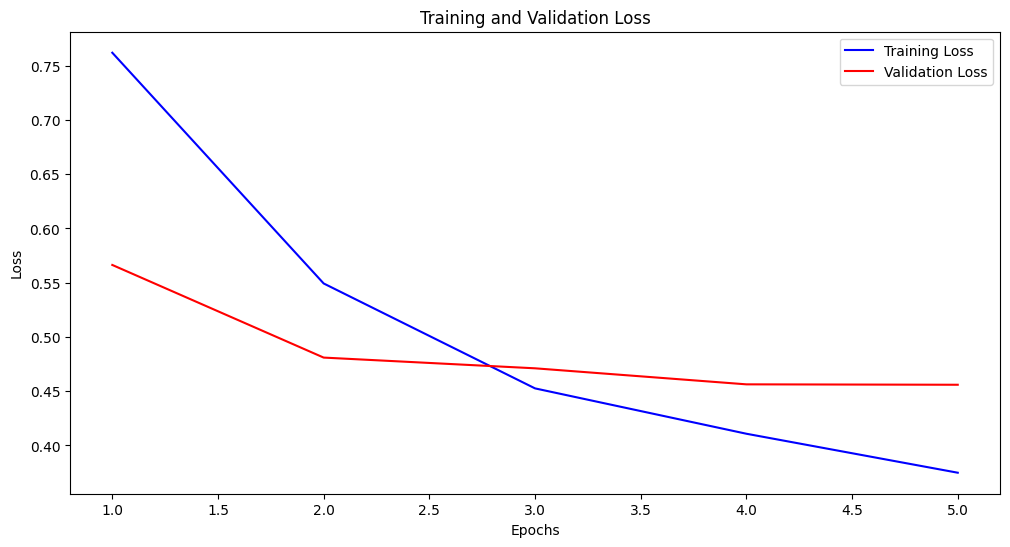

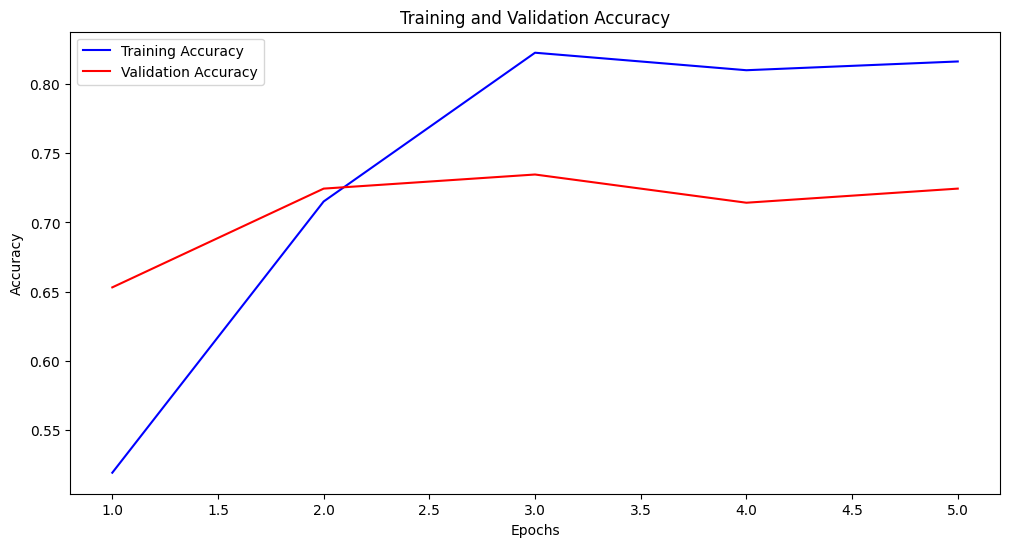

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


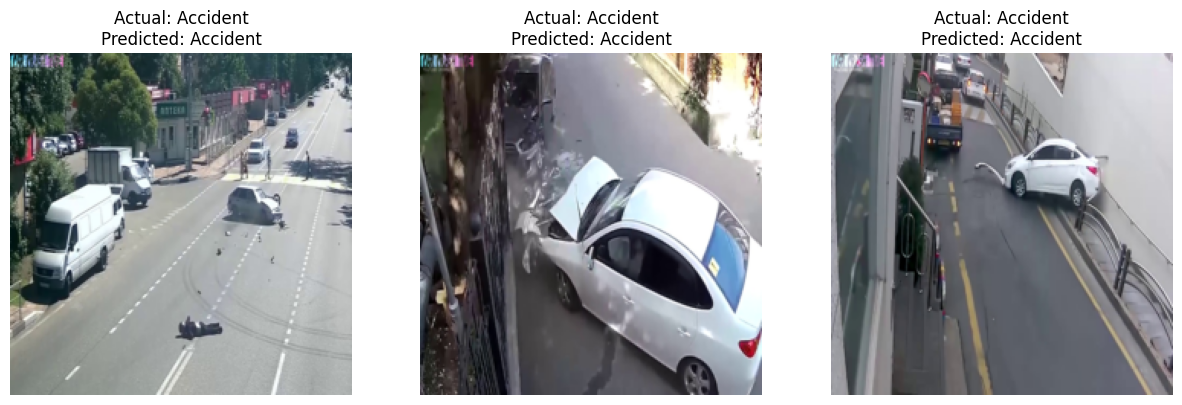

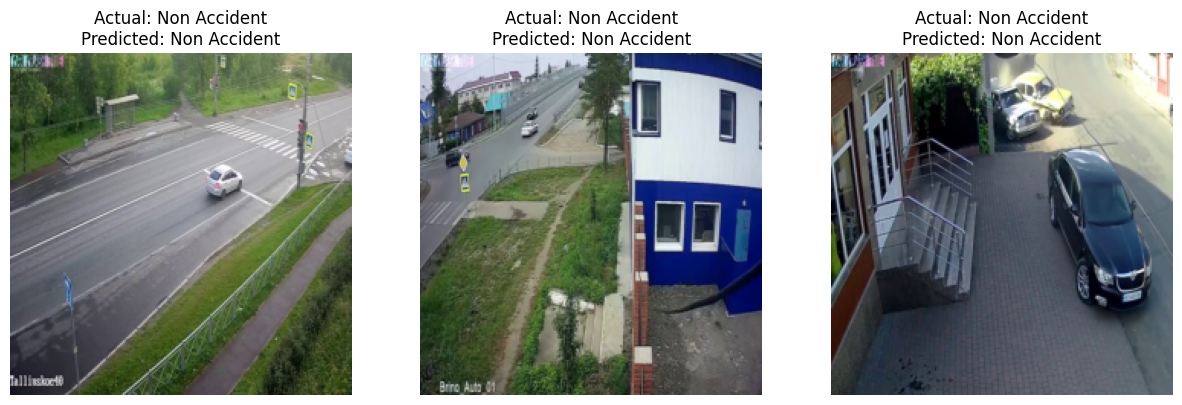

Classification Report:
              precision    recall  f1-score   support

Non Accident       0.74      0.75      0.74        52
    Accident       0.71      0.70      0.70        46

    accuracy                           0.72        98
   macro avg       0.72      0.72      0.72        98
weighted avg       0.72      0.72      0.72        98



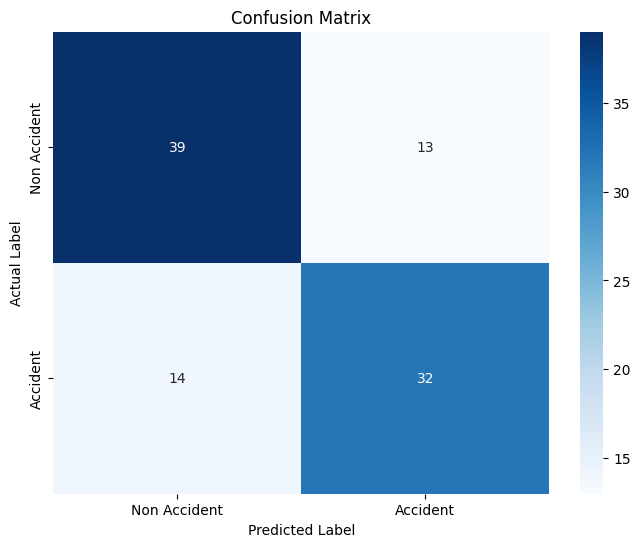

In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import random

# Load the history for plotting
history_vgg16 = torch.load('/content/drive/MyDrive/vgg16_history.pth')

# Plotting Accuracy and Loss Graphs
def plot_metrics(history):
    epochs = range(1, len(history['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_losses'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_losses'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_accuracies'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracies'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history_vgg16)

# Visualize Correct Predictions on the Validation Set with Shuffling
def visualize_correct_predictions(model, val_loader, num_images=3):
    model.eval()
    accident_images = []
    non_accident_images = []
    seen_images = set()

    # Shuffle the validation loader to get different images
    shuffled_indices = list(range(len(val_loader.dataset)))
    random.shuffle(shuffled_indices)

    with torch.no_grad():
        for idx in shuffled_indices:
            inputs, labels = val_loader.dataset[idx]
            inputs = inputs.unsqueeze(0).to(device)
            labels = torch.tensor([labels]).to(device)
            outputs = model(inputs)
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            label = labels.cpu().numpy()[0]

            if idx in seen_images:
                continue  # Skip already seen images

            # Collect correct accident predictions
            if preds[0] == 1 and label == 1 and len(accident_images) < num_images:
                accident_images.append((inputs[0].cpu(), label, preds[0]))
                seen_images.add(idx)
            # Collect correct non-accident predictions
            elif preds[0] == 0 and label == 0 and len(non_accident_images) < num_images:
                non_accident_images.append((inputs[0].cpu(), label, preds[0]))
                seen_images.add(idx)

            if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                break

    # Plot Correct Accident Predictions
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Accident\nPredicted: Accident')
        plt.axis('off')
    plt.show()

    # Plot Correct Non Accident Predictions
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(non_accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: Non Accident\nPredicted: Non Accident')
        plt.axis('off')
    plt.show()

# Load the trained model for visualization
model_vgg16 = models.vgg16(pretrained=False)
model_vgg16.classifier[6] = nn.Linear(model_vgg16.classifier[6].in_features, 1)
model_vgg16.load_state_dict(torch.load('/content/drive/MyDrive/vgg16_finetuned.pth'))
model_vgg16 = model_vgg16.to(device)

# Visualize correct predictions
visualize_correct_predictions(model_vgg16, val_loader, num_images=3)

# Function to get predictions and true labels
def get_predictions_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Generate Classification Report and Confusion Matrix
preds, labels = get_predictions_and_labels(model_vgg16, val_loader)

# Classification Report
print("Classification Report:")
print(classification_report(labels, preds, target_names=['Non Accident', 'Accident']))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
cm_df = pd.DataFrame(cm, index=['Non Accident', 'Accident'], columns=['Non Accident', 'Accident'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
